# This is for Evaluation

In [1]:
# API_FOR_OUTPUT
api_url = "http://127.0.0.1:8000/host/v3/chat/"

# CSV Structure

The dataset CSV should contain two columns:

- Property_ID - The property_id
- Input - Contains the input data
- Output - Contains the corresponding expected output

In [2]:
# llm_model_name = "gpt-4o"
llm_model_name = "gpt-4o-mini"
# llm_model_name = "gpt-4.1-nano"
# llm_model_name = "gpt-4.1"
# llm_model_name = "gpt-4.1-mini"
# llm_model_name = "gpt-5"
# llm_model_name = "gpt-5-nano"
# llm_model_name = "gpt-5-mini"

In [3]:
should_create_dataset = True
csv_url = "https://docs.google.com/spreadsheets/d/1tgpXeOjpEo__a8SER9EQ1VLIAHlB3atzPZevauPcMnM/export?format=csv"
dataset_name = "travela_eval_v2"
project_tracing_name = "Travela Evaluation API"


# Dataset Evaluation Variables
should_evaluate_dataset = True
experiment_name = llm_model_name+"-"+"outcomes"


# Correctness evaluation model
model_name = llm_model_name

In [4]:
# CORRECTNESS_PROMPT = """
# You are a helpful assistant for evaluating the correctness of an output.
# Given a user query, ground truth and the model's response, please assess the correctness of the output.
# Give a binary rating (1 for correct, 0 for incorrect) based on the ground truth. No explanation required at all.

# User Query: {user_query}
# Ground Truth: {ground_truth}
# Model Response: {model_response}
# """

CORRECTNESS_PROMPT = """
You are a helpful assistant for evaluating the correctness of an output.

Given a user query, ground truth, and the model's response, please assess the correctness of the output. The model's response may be in English, Banglish (Bangla written in English script), or Bangla.

Assign a binary rating (1 for correct, 0 for incorrect) based on whether the model's response reasonably aligns with the ground truth. But Note that no explanation required at all. Minor variations in phrasing or language are acceptable as long as the core meaning and content is correct. Also ignore the imojies or new line or spacial characters in the model response.

User Query: {user_query}

Ground Truth: {ground_truth}

Model Response: {model_response}
"""

# CORRECTNESS_PROMPT = """
# You are a helpful assistant for evaluating the correctness of an output.
# Given a user query, ground truth and the model's response, please assess the correctness of the output.
# The Model Response can be in English, Banglish (Bangla written in English script), or Bangla. Evaluate based on the meaning and content, regardless of the language used.
# Give a rating on a scale from 0 to 1 (e.g., 0.0 for completely incorrect, 1.0 for completely correct, and partial scores like 0.7 for partially correct) based on how well it matches the ground truth in substance and accuracy. No explanation required at all.
# User Query: {user_query}
# Ground Truth: {ground_truth}
# Model Response: {model_response}
# """

In [5]:
import requests
import json
import pandas as pd
from langsmith import Client
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
load_dotenv()

True

In [7]:
client = Client()

# Creating Dataset

In [8]:
if should_create_dataset:    
    df = pd.read_csv(csv_url)
    
    # Check if dataset already exists
    dataset_exists = False
    existing_examples = []
    
    try:
        if client.has_dataset(dataset_name=dataset_name):
            print(f"Dataset '{dataset_name}' already exists. Checking for updates...")
            dataset = client.read_dataset(dataset_name=dataset_name)
            dataset_exists = True
            
            # Get existing examples from LangSmith
            existing_examples = list(client.list_examples(dataset_name=dataset_name))
            print(f"Found {len(existing_examples)} existing examples in dataset.")
        else:
            # Create new dataset
            print(f"Creating new dataset: {dataset_name}")
            dataset = client.create_dataset(
                dataset_name=dataset_name,
                description="Dataset for evaluation",
            )
            print(f"Dataset '{dataset_name}' created successfully.")
    except Exception as e:
        print(f"Error checking/creating dataset: {e}")
        raise
    
    # Function to create a unique identifier for each example
    def create_example_hash(property_id, question, answer):
        """Create a unique hash for an example based on property_id, question, and answer"""
        content = f"{property_id}|{question}|{answer}"
        return hashlib.md5(content.encode()).hexdigest()
    
    # Create a set of existing example hashes for quick lookup
    existing_hashes = set()
    if dataset_exists:
        for example in existing_examples:
            prop_id = example.inputs.get('property_id', '')
            question = example.inputs.get('question', '')
            answer = example.outputs.get('ground_truth', '')
            example_hash = create_example_hash(prop_id, question, answer)
            existing_hashes.add(example_hash)
    
    # Prepare new examples from CSV
    new_examples = []
    updated_count = 0
    skipped_count = 0
    
    for index, row in df.iterrows():
        property_id = str(row["Property_ID"])
        question = str(row["Input"])
        answer = str(row["Output"])
        
        # Create hash for this example
        example_hash = create_example_hash(property_id, question, answer)
        
        # Check if this example already exists
        if example_hash not in existing_hashes:
            new_examples.append({
                "inputs": {
                    "question": question,
                    "property_id": property_id,
                },
                "outputs": {
                    "ground_truth": answer,
                },
                "metadata": {
                    "property_id": property_id,
                    "example_hash": example_hash,
                    "source": "csv_import",
                    "import_timestamp": pd.Timestamp.now().isoformat()
                }
            })
            updated_count += 1
        else:
            skipped_count += 1
    
    # Add new examples to the dataset
    if new_examples:
        try:
            client.create_examples(
                dataset_id=dataset.id,
                examples=new_examples
            )
            print(f"Successfully added {len(new_examples)} new examples to dataset '{dataset_name}'.")
            print(f"Summary: {updated_count} new, {skipped_count} skipped (already exist)")
        except Exception as e:
            print(f"Error adding examples to dataset: {e}")
            raise
    else:
        print(f"No new examples to add. All {len(df)} examples from CSV already exist in the dataset.")
    
    # Show dataset statistics
    try:
        final_examples = list(client.list_examples(dataset_name=dataset_name))
        print(f"Dataset '{dataset_name}' now contains {len(final_examples)} total examples.")
    except Exception as e:
        print(f"Warning: Could not retrieve final dataset statistics: {e}")

Dataset 'travela_eval_v2' already exists. Checking for updates...
Found 24 existing examples in dataset.
Successfully added 35 new examples to dataset 'travela_eval_v2'.
Summary: 35 new, 24 skipped (already exist)
Dataset 'travela_eval_v2' now contains 59 total examples.


In [9]:

def get_target_output(inputs: dict, metadata: dict) -> dict:
    print(f"Inputs: {inputs}")
    print(f"Metadata: {metadata}")
    
    response = requests.post(
        f"{api_url}",
        headers={
            'Content-Type': 'application/json',
        },
        data=json.dumps({
            'property_id': str(metadata['property_id']),
            'question': inputs['question'],
        })
    )
    
    resp = response.json()
    print(f"Response: {resp}")
    
    # Extract chat_response
    chat_response = resp.get("data", {}).get("chat_response", {})
    
    return {
        "answer": chat_response.get("answer", ""),
        "tokens_used": chat_response.get("tokens_used", 0),
        "cost": chat_response.get("cost", 0.0),
        "session_id": chat_response.get("session_id", ""),
    }

In [10]:

def correctness_evaluator(inputs: dict, outputs: dict, reference_outputs: dict):
    llm = ChatOpenAI(model=model_name, temperature=0)

    final_prompt = CORRECTNESS_PROMPT.format(
        user_query=inputs['question'],
        ground_truth=reference_outputs['ground_truth'],
        model_response=outputs['answer']
    )

    response = llm.invoke(final_prompt)

    return int(response.content.strip())

def tokens(inputs: dict, outputs: dict, reference_outputs: dict):
    """Extract token count from outputs"""
    return outputs.get('tokens_used', 0)

def cost(inputs: dict, outputs: dict, reference_outputs: dict):
    """Extract cost from outputs"""
    return str(outputs.get('cost', 0.0))

if should_evaluate_dataset:
    result = client.evaluate(
        get_target_output,
        data=dataset_name,
        evaluators=[correctness_evaluator, tokens, cost],
        experiment_prefix=experiment_name,
    )

View the evaluation results for experiment: 'gpt-4o-mini-outcomes-c82d3ebb' at:
https://smith.langchain.com/o/7e7692da-3753-4bfe-9f38-6b2a56796df9/datasets/8a21f5dd-ae8a-4625-b7c1-549420ad2346/compare?selectedSessions=c0a8bc7c-a7e4-441d-9dba-4f162cadcff0




0it [00:00, ?it/s]

Inputs: {'question': 'Maximum koto jon guest thakte parbe?', 'property_id': '4490'}
Metadata: {'source': 'csv_import', 'property_id': '4490', 'example_hash': '504771e7a316f28dd78c233a6e0f7fa9', 'dataset_split': ['base'], 'import_timestamp': '2025-09-03T19:54:00.477001'}
Response: {'status': 200, 'data': {'chat_response': {'answer': '2 jon', 'tokens_used': 1347, 'cost': 9.675e-05, 'session_id': '433c97b5-3810-465e-ac95-efa3399542a8', 'source_documents': ['<think> The query is in Romanized Bangla, as it uses the Roman alphabet to convey a question that is typically asked in Bangla. I will translate it to Bangla. </think>\n\n<answer>সর্বাধিক কতজন অতিথি থাকতে পারবে?</answer>\n<language>Romanized Bangla</language>', '<think> \nTo answer this question, we need to look at the property description and find the information related to the maximum number of guests allowed. \nThe property description mentions "Max Guests: 2", which indicates the maximum number of guests that can stay.\n</think>\n\

In [11]:
result

,inputs.question,inputs.property_id,outputs.answer,outputs.tokens_used,outputs.cost,outputs.session_id,error,reference.ground_truth,feedback.correctness_evaluator,feedback.tokens,feedback.cost,execution_time,example_id,id
0,Maximum koto jon guest thakte parbe?,4490,2 jon,1347,0.000097,433c97b5-3810-465e-ac95-efa3399542a8,None,Maximum 2 jon guest.,1,1347,9.675e-05,15.628866,0cb59579-5fa9-4988-8932-ac94b7d55c52,ca0329ab-8da8-47de-8ac2-84a4d99118e2
1,Couples der jonno suitable?,4490,"Hyan, kapolder jonyo upojukto.",1416,0.000100,d28c3def-efed-4ae7-9fe4-11a5dfd134a0,None,"Hae, peaceful AC room for couples.",1,1416,0.0001002,10.229551,1440ddd5-17bc-4d44-8395-3ea694735bf0,a55215a3-7b78-436a-9038-50178b53a463
2,Room ta ki safe?,4490,"Hya, rumta 100% safe ebong surakshit.",1377,0.000103,8a57d01a-d2e1-43be-929d-8afc21a2a9b2,None,"Hae, 100% safe and secure.",1,1377,0.00010304999999999998,10.019691,16330175-95d6-46d3-9e0d-66b8655019f2,cb0afae4-8089-4b32-8fc3-9f0b54d153e3
3,Khawa ranna korte parbo?,4109,"Hya, ranna korar byabostha ache. Puropurti kar...",1511,0.000110,639c29d7-2289-4409-a963-eca3ec658146,None,"Ji, Kitchen available",1,1511,0.00010964999999999998,6.298251,2a329744-2260-484b-8ccf-b37f21381ef2,a6117a5f-1d69-4b3a-8534-462baeeccb35
4,Amra 7 jon thakte parbo,4109,"Hyan, 7 jon thakte parben",1388,0.000106,5fc55b27-9bb8-4d0b-abad-2ca19ee0e3ea,None,Hae possible,1,1388,0.00010649999999999999,10.384874,2b2af09c-4aa4-411b-a4a2-7c91321c1997,d428eb20-a85b-470e-b836-905b968a5b74
5,Bathroom koto ta?,4490,ekta,1345,0.000098,765b9b24-5903-4de5-bbb9-9d074cbd552c,None,1 bathroom.,0,1345,9.779999999999999e-05,9.253982,31c3d6e7-8088-4ab5-9c33-6a506681bfe4,5387b088-5d27-4049-b88b-6c379a5ee04c
6,Infant allow kore?,4490,na,1312,0.000087,0b74d27d-9741-41d3-988f-cd09d5475ce6,None,Maximum 2 guests allowed. Children need to be ...,0,1312,8.714999999999999e-05,9.480898,3465f351-d078-4f66-ada5-57612d12cf9e,25f56142-c816-4e69-80d4-85d9aec97f53
7,Room tai AC ache?,4490,"Hya, rumtate AC ache.",1371,0.000104,763b9210-0c4a-4d5e-a8ac-509dfef30c50,None,"Hae, fully air-conditioned.",1,1371,0.00010379999999999999,9.718882,34a13f78-4759-429b-bd62-f8c313144d8d,0643e8f8-8112-468c-96ea-c8ee2070f630
8,Service charge koto?,4490,100 taka,1323,0.000097,0063f8a6-5918-44e4-bcf8-6dfa73116f92,None,100tk before check-in.,1,1323,9.719999999999999e-05,8.018422,35e68082-66db-4e07-98eb-9ea8623daa41,229a9fbf-dd8d-4a9b-b169-7ff2f9b3e132
9,Minimum kotodin stay korte hobe?,4490,ek din,1349,0.000104,ebe7d41b-ffdd-4fe1-ae72-8ee36f3e572b,None,Minimum 1 night.,0,1349,0.00010424999999999999,6.391528,460179b5-f428-4afd-b7b8-9895c864afed,d6aa0d2e-795b-40b2-a5f4-a2eab1ff2ced


In [12]:
# Convert result to DataFrame for easier analysis
df_results = result.to_pandas()
def process_correctness_score(score):
    if pd.isna(score):
        return 0
    if isinstance(score, str):
        # If it's a string of 1s and 0s, take the first character
        if score and score[0] in ['0', '1']:
            return int(score[0])
        # Try to convert to int/float
        try:
            return int(float(score))
        except:
            return 0
    try:
        return int(float(score))
    except:
        return 0

df_results['correctness_numeric'] = df_results['feedback.correctness_evaluator'].apply(process_correctness_score)

In [13]:
# Basic Statistics
print("\nOVERALL PERFORMANCE METRICS")
print("-" * 50)
correctness_scores = df_results['correctness_numeric']
total_tests = len(df_results)
correct_answers = correctness_scores.sum()
accuracy = (correct_answers / total_tests) * 100

print(f"Total Test Cases: {total_tests}")
print(f"Correct Answers: {int(correct_answers)}")
print(f"Incorrect Answers: {total_tests - int(correct_answers)}")
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Average Execution Time: {df_results['execution_time'].mean():.2f} seconds")
print(f"Total Execution Time: {df_results['execution_time'].sum():.2f} seconds")


OVERALL PERFORMANCE METRICS
--------------------------------------------------
Total Test Cases: 59
Correct Answers: 40
Incorrect Answers: 19
Overall Accuracy: 67.80%
Average Execution Time: 8.28 seconds
Total Execution Time: 488.67 seconds


In [14]:
# Property-wise Performance
print("\nPROPERTY-WISE PERFORMANCE")
print("-" * 50)
property_performance = df_results.groupby('inputs.property_id').agg({
    'correctness_numeric': ['count', 'sum', 'mean'],
    'execution_time': ['mean', 'std']
}).round(2)

property_performance.columns = ['Total_Tests', 'Correct_Answers', 'Accuracy', 'Avg_Time', 'Time_Std']
property_performance['Accuracy'] = (property_performance['Accuracy'] * 100).round(2)
property_performance = property_performance.sort_values('Accuracy', ascending=False)

print(property_performance)

failed_tests = df_results[df_results['correctness_numeric'] == 0]


PROPERTY-WISE PERFORMANCE
--------------------------------------------------
                    Total_Tests  Correct_Answers  Accuracy  Avg_Time  Time_Std
inputs.property_id                                                            
272                          10                8      80.0      9.52      3.05
10                            9                6      67.0     10.15      4.27
4109                         18               12      67.0      7.76      2.05
4490                         22               14      64.0      7.38      2.52


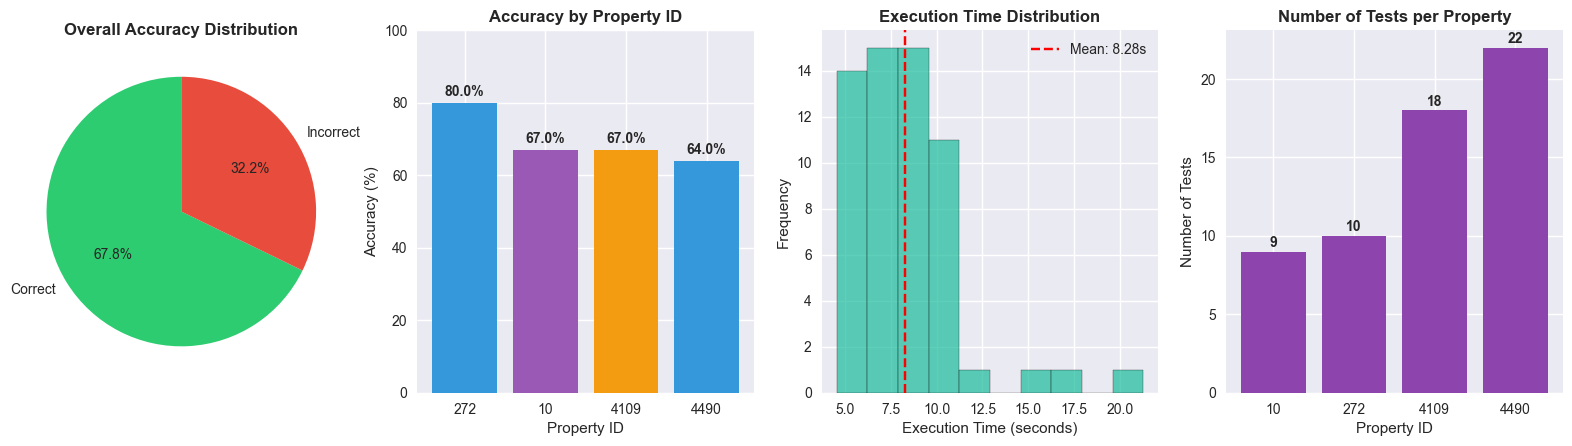

In [15]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 16))

# Overall Accuracy Pie Chart
plt.subplot(3, 4, 1)
labels = ['Correct', 'Incorrect']
sizes = [correct_answers, total_tests - correct_answers]
colors = ['#2ecc71', '#e74c3c']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Overall Accuracy Distribution', fontsize=12, fontweight='bold')

# Property-wise Accuracy Bar Chart
plt.subplot(3, 4, 2)
props = property_performance.index.astype(str)
accuracies = property_performance['Accuracy'].values
bars = plt.bar(props, accuracies, color=['#3498db', '#9b59b6', '#f39c12'])
plt.title('Accuracy by Property ID', fontsize=12, fontweight='bold')
plt.xlabel('Property ID')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Execution Time Distribution
plt.subplot(3, 4, 3)
plt.hist(df_results['execution_time'], bins=10, color='#1abc9c', alpha=0.7, edgecolor='black')
plt.axvline(df_results['execution_time'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_results["execution_time"].mean():.2f}s')
plt.title('Execution Time Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Frequency')
plt.legend()

# Property-wise Test Count
plt.subplot(3, 4, 4)
test_counts = df_results['inputs.property_id'].value_counts().sort_index()
bars = plt.bar(test_counts.index.astype(str), test_counts.values, color='#8e44ad')
plt.title('Number of Tests per Property', fontsize=12, fontweight='bold')
plt.xlabel('Property ID')
plt.ylabel('Number of Tests')
# Add value labels
for bar, count in zip(bars, test_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold')

In [16]:
print(f"\nPerformance Insights:")
print("-" * 30)
fastest_test = df_results.loc[df_results['execution_time'].idxmin()]
slowest_test = df_results.loc[df_results['execution_time'].idxmax()]
print(f"Fastest Response: {fastest_test['execution_time']:.2f}s - Property {fastest_test['inputs.property_id']}")
print(f"Slowest Response: {slowest_test['execution_time']:.2f}s - Property {slowest_test['inputs.property_id']}")
print(f"Most Accurate Property: {property_performance.index[0]} ({property_performance.iloc[0]['Accuracy']:.1f}%)")
print(f"Least Accurate Property: {property_performance.index[-1]} ({property_performance.iloc[-1]['Accuracy']:.1f}%)")


Performance Insights:
------------------------------
Fastest Response: 4.57s - Property 272
Slowest Response: 21.25s - Property 10
Most Accurate Property: 272 (80.0%)
Least Accurate Property: 4490 (64.0%)


In [17]:
# Statistical Summary
print(f"\nSTATISTICAL SUMMARY")
print("-" * 30)
print(f"Confidence Interval (95%): {accuracy:.2f}% ± {1.96 * np.sqrt(accuracy * (100 - accuracy) / total_tests):.2f}%")
print(f"Standard Error: {np.sqrt(accuracy * (100 - accuracy) / total_tests):.2f}%")

if total_tests > 1:
    print(f"Performance Consistency: {100 - (correctness_scores.std() * 100):.2f}%")


STATISTICAL SUMMARY
------------------------------
Confidence Interval (95%): 67.80% ± 11.92%
Standard Error: 6.08%
Performance Consistency: 52.87%
